In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [4]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000049.png")

In [73]:
from fundamental_matrix import keypoint_matcher

Before filtering neighbours: 100. After: 31


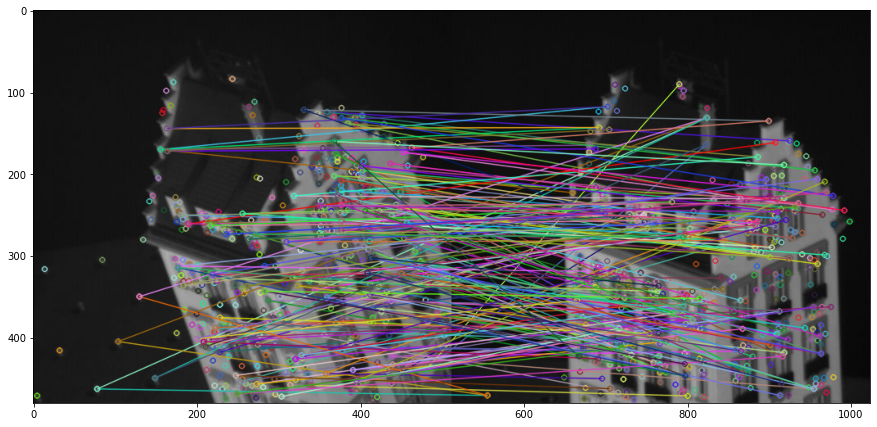

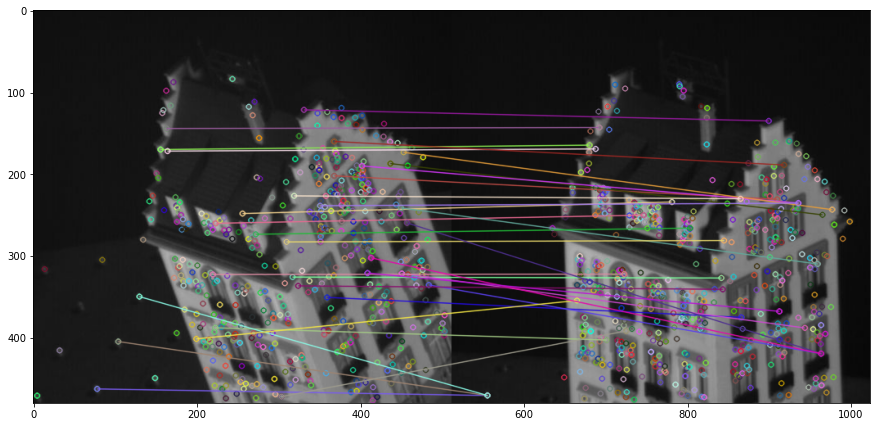

In [89]:
matches, points1, points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                       random_n=100, 
                                                       filter_neighbours=True, 
                                                       draw_matches=True)